In [4]:
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

In [5]:
def waterfall(index, data, Title="Example chart", x_lab="Example Increment", y_lab="example values",
              formatting = "{:,.1f}", green_color='#29EA38', red_color='#FB3C62', blue_color='#24CAFF',
             sorted_value = False, threshold=None, other_label='other', net_label='net'):
    '''
    Given two sequences ordered appropriately, generate a standard waterfall chart.
    Optionally modify the title, axis labels, number formatting, bar colors, 
    increment sorting, and thresholding. Thresholding groups lower magnitude changes
    into a combined group to display as a single entity on the chart.
    '''
    
    #convert data and index to np.array
    index=np.array(index)
    data=np.array(data)
    
    #sorted by absolute value 
    if sorted_value: 
        abs_data = abs(data)
        data_order = np.argsort(abs_data)[::-1]
        data = data[data_order]
        index = index[data_order]
    
    #group contributors less than the threshold into 'other' 
    if threshold:
        
        abs_data = abs(data)
        threshold_v = abs_data.max()*threshold
        
        if threshold_v > abs_data.min():
            index = np.append(index[abs_data>=threshold_v],other_label)
            data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))
    
    changes = {'amount' : data}
    
    #define format formatter
    def money(x, pos):
        'The two args are the value and tick position'
        return formatting.format(x)
    formatter = FuncFormatter(money)
    
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    #Store data and create a blank series to use for the waterfall
    trans = pd.DataFrame(data=changes,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)
    
    trans['positive'] = trans['amount'] > 0
    #Get the net total number for the final element in the waterfall
    total = trans.sum().amount
    trans.loc[net_label]= total
    blank.loc[net_label] = total
    #The steps graphically show the levels as well as used for label placement
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan
    #When plotting the last element, we want to show the full bar,
    #Set the blank to 0
    blank.loc[net_label] = 0
    
    #define bar colors for net bar
    trans.loc[trans['positive'] > 1, 'positive'] = 99
    trans.loc[trans['positive'] < 0, 'positive'] = 99
    trans.loc[(trans['positive'] > 0) & (trans['positive'] < 1), 'positive'] = 99
    
    trans['color'] = trans['positive']
    
    trans.loc[trans['positive'] == 1, 'color'] = green_color
    trans.loc[trans['positive'] == 0, 'color'] = red_color
    trans.loc[trans['positive'] == 99, 'color'] = blue_color
    
    
    print(trans)
    
    my_colors = list(trans.color)
    
    print(my_colors)
    
    print(blank)
    
    #Plot and label
    my_plot = plt.bar(range(0,len(trans.index)), blank, width=0.5, color='white')
    my_plot = plt.bar(range(0,len(trans.index)), trans.amount, width=0.6,
             bottom=blank, color=my_colors)       
                                   
    
    # connecting lines
    #my_plot = lines.Line2D(step.index, step.values,'k', linewidth = 0.3, color = "gray")
    #my_plot = lines.Line2D([10,0], [1,10])
    
    #axis labels
    my_plot = plt.xlabel("\n" + x_lab)
    my_plot = plt.ylabel(y_lab + "\n")
    #Get the y-axis position for the labels
    y_height = trans.amount.cumsum().shift(1).fillna(0)
    
    temp = list(trans.amount)
    
    # create dynamic chart range
    for i in range(len(temp)):
        if (i > 0) & (i < (len(temp) - 1)):
            temp[i] = temp[i] + temp[i-1]
    
    trans['temp'] = temp
            
    plot_max = trans['temp'].max()
    plot_min = trans['temp'].min()
    
    #Make sure the plot doesn't accidentally focus only on the changes in the data
    if all(i >= 0 for i in temp):
        plot_min = 0
    if all(i < 0 for i in temp):
        plot_max = 0
    
    if abs(plot_max) >= abs(plot_min):
        maxmax = abs(plot_max)   
    else:
        maxmax = abs(plot_min)
        
    pos_offset = maxmax / 50
    
    plot_offset = maxmax / 15 ## needs to me cumulative sum dynamic
    #Start label loop
    loop = 0
    for index, row in trans.iterrows():
        # For the last item in the list, we don't want to double count
        if row['amount'] == total:
            y = y_height[loop]
        else:
            y = y_height[loop] + row['amount']
        # Determine if we want a neg or pos offset
        if row['amount'] > 0:
            y += (pos_offset*1.4)
            my_plot = plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'g')
        else:
            y -= (pos_offset*4)
            my_plot = plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'r')
        loop+=1
#     #Scale up the y axis so there is room for the labels
    my_plot = plt.ylim(plot_min-round(2*plot_offset, 7),plot_max+round(2*plot_offset, 7))
#     #Rotate the labels
    my_plot = plt.xticks(range(0,len(trans)), trans.index, rotation=45)
    my_plot = plt.axhline(0, color='black', linewidth = 0.6)
    return my_plot

In [6]:
a = ['sales','returns','credit fees','rebates','late charges','shipping']
b = [10,-30,-7.5,-25,95,-7]

              amount  positive    color
sales           10.0       1.0  #29EA38
returns        -30.0       0.0  #FB3C62
credit fees     -7.5       0.0  #FB3C62
rebates        -25.0       0.0  #FB3C62
late charges    95.0       1.0  #29EA38
shipping        -7.0       0.0  #FB3C62
net             35.5      99.0  #24CAFF
['#29EA38', '#FB3C62', '#FB3C62', '#FB3C62', '#29EA38', '#FB3C62', '#24CAFF']
sales            0.0
returns         10.0
credit fees    -20.0
rebates        -27.5
late charges   -52.5
shipping        42.5
net              0.0
Name: amount, dtype: float64


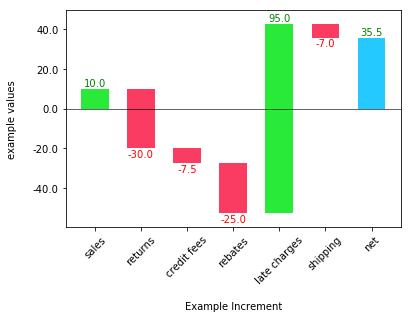

In [7]:
waterfall(a,b)